# Imports

In [321]:
# analysis
import pandas as pd
import numpy as np
from scipy import stats

# visuals
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from itertools import combinations

# preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler, PolynomialFeatures

# feature selection
from sklearn.feature_selection import VarianceThreshold, SelectPercentile

# decomposition
from sklearn.decomposition import PCA

# ensemble
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier

# logistic regression
from sklearn.linear_model import LogisticRegression

# naive bayes
from sklearn.naive_bayes import GaussianNB

# process classifier
from sklearn.gaussian_process import GaussianProcessClassifier

# neighbors
from sklearn.neighbors import KNeighborsClassifier

# neural networks
from sklearn.neural_network import MLPClassifier

# support vector machines
from sklearn.svm import LinearSVC, SVC

# train test split, tuning, and score validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# classification report
from sklearn.metrics import classification_report

%matplotlib inline

# Classifiers

In [209]:
classifiers = {
    'AdaBoostClassifier' : AdaBoostClassifier(random_state=0),
    'ExtraTreesClassifier' : ExtraTreesClassifier(n_estimators=100, random_state=0),
    'RandomForestClassifier' : RandomForestClassifier(n_estimators=100, random_state=0),
    'LogisticRegression' : LogisticRegression(solver='lbfgs', multi_class='auto', random_state=0, max_iter=200),
    'GaussianNB' : GaussianNB(),
    'GaussianProcessClassifier' : GaussianProcessClassifier(random_state=0),
    'KNeighborsClassifier' : KNeighborsClassifier(),
    'MLPClassifier' : MLPClassifier(random_state=0, max_iter=1500),
    'LinearSVC' : LinearSVC(random_state=0, max_iter=2000),
    'SVC' : SVC(gamma='scale', random_state=0)
}

# Ensembles

In [210]:
ensembles = {
    'AdaBoostClassifier' : AdaBoostClassifier(random_state=0),
    'ExtraTreesClassifier' : ExtraTreesClassifier(n_estimators=100, random_state=0),
    'RandomForestClassifier' : RandomForestClassifier(n_estimators=100, random_state=0)
}

# Data

In [211]:
# read training data
train = pd.read_csv("train.csv")

In [212]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
id               371 non-null int64
bone_length      371 non-null float64
rotting_flesh    371 non-null float64
hair_length      371 non-null float64
has_soul         371 non-null float64
color            371 non-null object
type             371 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 20.4+ KB


In [213]:
train.describe()

,id,bone_length,rotting_flesh,hair_length,has_soul
count,371.000000,371.000000,371.000000,371.000000,371.000000
mean,443.676550,0.434160,0.506848,0.529114,0.471392
std,263.222489,0.132833,0.146358,0.169902,0.176129
min,0.000000,0.061032,0.095687,0.134600,0.009402
25%,205.500000,0.340006,0.414812,0.407428,0.348002
50%,458.000000,0.434891,0.501552,0.538642,0.466372
75%,678.500000,0.517223,0.603977,0.647244,0.600610
max,897.000000,0.817001,0.932466,1.000000,0.935721


In [214]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


# Categorical Features

In [215]:
train.describe(include=['O'])

,color,type
count,371,371
unique,6,3
top,white,Ghoul
freq,137,129


We want to predict the `type` field.

In [216]:
train.color.unique()

array(['clear', 'green', 'black', 'white', 'blue', 'blood'], dtype=object)

In [217]:
# get dummy color features
train = train.join(pd.get_dummies(train.color))

# Deviations From Normality

In [218]:
# does bone_length deviate from normal distribution?
stats.normaltest(train.bone_length)

NormaltestResult(statistic=0.6742550901699862, pvalue=0.7138177901456553)

In [219]:
# does rotting_flesh deviate from normal distribution?
stats.normaltest(train.rotting_flesh)

NormaltestResult(statistic=0.22672795635859264, pvalue=0.8928256319200829)

In [220]:
# does hair_length deviate from normal distribution?
stats.normaltest(train.hair_length)

NormaltestResult(statistic=5.0695972190717296, pvalue=0.07927768342662347)

In [221]:
# does has_soul deviate from normal distribution?
stats.normaltest(train.has_soul)

NormaltestResult(statistic=2.1606868954472525, pvalue=0.3394789123611325)

None of the continuous features deviate from the normal distribution.

Flag observations that fall outside 1 standard deviation from all continuous features.

In [222]:
# flag if observation falls within 1 std of mean bone_length
train['bone_length_std1'] = (train.bone_length >= (train.bone_length.mean() - train.bone_length.std())) \
& (train.bone_length <= (train.bone_length.mean() + train.bone_length.std()))

In [223]:
# flag if observation is < mean bone_length - 1 std
train['bone_length_lt1std'] = train.bone_length < (train.bone_length.mean() - train.bone_length.std())

# flag if observation is > mean bone_length + 1 std
train['bone_length_gt1std'] = train.bone_length > (train.bone_length.mean() + train.bone_length.std())

In [224]:
# flag if observation falls within 1 std of mean rotting_flesh
train['rotting_flesh_std1'] = (train.rotting_flesh >= (train.rotting_flesh.mean() - train.rotting_flesh.std())) \
& (train.rotting_flesh <= (train.rotting_flesh.mean() + train.rotting_flesh.std()))

In [225]:
# flag if observation is < mean rotting_flesh - 1 std
train['rotting_flesh_lt1std'] = train.rotting_flesh < (train.rotting_flesh.mean() - train.rotting_flesh.std())

# flag if observation is > mean rotting_flesh + 1 std
train['rotting_flesh_gt1std'] = train.rotting_flesh > (train.rotting_flesh.mean() + train.rotting_flesh.std())

In [226]:
# flag if observation falls within 1 std of mean hair_length
train['hair_length_std1'] = (train.hair_length >= (train.hair_length.mean() - train.hair_length.std())) \
& (train.hair_length <= (train.hair_length.mean() + train.hair_length.std()))

In [227]:
# flag if observation is < mean hair_length - 1 std
train['hair_length_lt1std'] = train.hair_length < (train.hair_length.mean() - train.hair_length.std())

# flag if observation is > mean hair_length + 1 std
train['hair_length_gt1std'] = train.hair_length > (train.hair_length.mean() + train.hair_length.std())

In [228]:
# flag if observation falls within 1 std of mean has_soul
train['has_soul_std1'] = (train.has_soul >= (train.has_soul.mean() - train.has_soul.std())) \
& (train.has_soul <= (train.has_soul.mean() + train.has_soul.std()))

In [229]:
# flag if observation is < mean has_soul - 1 std
train['has_soul_lt1std'] = train.has_soul < (train.has_soul.mean() - train.has_soul.std())

# flag if observation is > mean has_soul + 1 std
train['has_soul_gt1std'] = train.has_soul > (train.has_soul.mean() + train.has_soul.std())

# Feature Importance

In [230]:
# com = []

# for i in range(2, train.color.nunique()):
#     els = [list(x) for x in combinations(train.color.unique(), i)]
    
#     com.extend(els)

# for c in com:
#     train['_'.join(c)] = train.loc[:, c].sum(axis=1)

In [231]:
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)

poly_numeric = poly.fit_transform(train.drop(columns=[
    'id',
    'type',
    'color',
]))

train = train.loc[:, [
    'id',
    'type',
    'color',
]].join(pd.DataFrame(
    data=poly_numeric,
    columns=poly.get_feature_names(train.drop(columns=[
        'id',
        'type',
        'color',
    ]).columns.tolist())
))

In [239]:
# select X features
X = train.drop(columns=[
    'id',
    'color',
    'type',
])

# select y for training
y = train.type

# define scaler
scaler = MinMaxScaler()
rscaler = RobustScaler()

# scale X
X_ = pd.DataFrame(
    data=scaler.fit_transform(X),
    index=X.index,
    columns=X.columns
)

X_r = pd.DataFrame(
    data=rscaler.fit_transform(X),
    index=X.index,
    columns=X.columns
)

# define variance threshold
vt = VarianceThreshold(threshold=0.0)

# redefine X based on vt_X
X_ = pd.DataFrame(
    data=vt.fit_transform(X_),
    index=X_.index,
    columns=X_.columns[vt.get_support()]
)

# redefine X based on vt_X
X_r = pd.DataFrame(
    data=vt.fit_transform(X_r),
    index=X_r.index,
    columns=X_r.columns[vt.get_support()]
)

# define selector
selector = SelectPercentile(percentile=10)

# keep top 10 percent of features
X_ = pd.DataFrame(
    data=selector.fit_transform(X_, y),
    index=X_.index,
    columns=X_.columns[selector.get_support()]
)

# keep top 10 percent of features
X_r = pd.DataFrame(
    data=selector.fit_transform(X_r, y),
    index=X_r.index,
    columns=X_r.columns[selector.get_support()]
)

# # define pca
# pca = PCA(n_components=0.99, random_state=0)

# # redefine X_ and X_r
# X_ = pca.fit_transform(X_)
# X_r = pca.fit_transform(X_r)

In [240]:
fi = {}

for k,v in ensembles.items():
    fi[k] = v.fit(X_, y).feature_importances_

fi = pd.DataFrame.from_dict(fi, orient='index', columns=X_.columns)

fi.sort_values(fi.columns.tolist(), ascending=False, inplace=True)
fi.sort_values(fi.index.tolist(), axis=1, ascending=False, inplace=True)

fi.style.highlight_max(axis=1)

,bone_length hair_length has_soul,hair_length has_soul^2,bone_length hair_length^2,bone_length^2 hair_length,hair_length has_soul,hair_length^2 has_soul,hair_length^2,rotting_flesh^3,rotting_flesh^2,rotting_flesh,bone_length hair_length,hair_length^3,has_soul,bone_length^2 has_soul,bone_length hair_length has_soul_std1,rotting_flesh hair_length has_soul,hair_length,has_soul_lt1std^2,bone_length has_soul^2,bone_length has_soul,bone_length hair_length rotting_flesh_std1,bone_length rotting_flesh has_soul,rotting_flesh has_soul,bone_length,bone_length rotting_flesh hair_length,bone_length^2 rotting_flesh_std1,hair_length^2 has_soul_std1,has_soul_lt1std^3,has_soul^3,rotting_flesh hair_length_lt1std^2,bone_length hair_length hair_length_std1,has_soul_lt1std,hair_length has_soul hair_length_std1,bone_length^2,hair_length hair_length_std1 has_soul_std1,rotting_flesh hair_length,bone_length has_soul hair_length_std1,rotting_flesh hair_length^2,hair_length_lt1std^3,bone_length^3,bone_length has_soul rotting_flesh_std1,hair_length has_soul_std1,has_soul^2,hair_length has_soul bone_length_std1,rotting_flesh has_soul^2,hair_length rotting_flesh_std1,has_soul rotting_flesh_std1,hair_length has_soul has_soul_std1,hair_length has_soul_std1^2,hair_length^2 rotting_flesh_std1,bone_length hair_length_std1 has_soul_std1,has_soul^2 rotting_flesh_std1,has_soul^2 bone_length_std1,bone_length^2 rotting_flesh,hair_length^2 bone_length_std1,hair_length has_soul rotting_flesh_std1,rotting_flesh hair_length_lt1std,has_soul rotting_flesh_std1^2,bone_length rotting_flesh has_soul_lt1std,hair_length rotting_flesh_std1^2,rotting_flesh hair_length hair_length_gt1std,hair_length_gt1std^2,rotting_flesh has_soul_lt1std^2,hair_length hair_length_gt1std,hair_length_lt1std,rotting_flesh has_soul hair_length_gt1std,hair_length has_soul_lt1std,bone_length has_soul_lt1std^2,bone_length hair_length_gt1std^2,bone_length has_soul_gt1std^2,hair_length has_soul_lt1std^2,bone_length rotting_flesh hair_length_lt1std,hair_length_gt1std^3,rotting_flesh hair_length_gt1std^2,hair_length hair_length_lt1std^2,rotting_flesh has_soul_gt1std,has_soul hair_length_gt1std^2,rotting_flesh^2 hair_length_lt1std,has_soul_gt1std,has_soul has_soul_lt1std,rotting_flesh^2 bone_length_lt1std,bone_length has_soul has_soul_gt1std,has_soul has_soul_lt1std^2,hair_length_lt1std^2,rotting_flesh bone_length_lt1std^2,has_soul hair_length_gt1std,has_soul has_soul_gt1std,bone_length hair_length has_soul_gt1std,bone_length rotting_flesh hair_length_gt1std,rotting_flesh hair_length hair_length_lt1std,bone_length has_soul_lt1std,hair_length_gt1std,bone_length hair_length hair_length_lt1std,bone_length hair_length has_soul_lt1std,bone_length has_soul hair_length_gt1std,hair_length^2 hair_length_lt1std,has_soul has_soul_gt1std^2,rotting_flesh bone_length_lt1std,hair_length has_soul bone_length_gt1std,bone_length^2 has_soul_gt1std,bone_length hair_length bone_length_gt1std,bone_length hair_length_lt1std^2,rotting_flesh hair_length has_soul_lt1std,has_soul^2 has_soul_gt1std,has_soul^2 hair_length_gt1std,rotting_flesh bone_length_std1 hair_length_lt1std,hair_length has_soul_gt1std,rotting_flesh has_soul has_soul_gt1std,bone_length has_soul_gt1std,hair_length has_soul_gt1std^2,rotting_flesh hair_length_gt1std,rotting_flesh hair_length has_soul_gt1std,rotting_flesh has_soul_lt1std,bone_length rotting_flesh has_soul_gt1std,bone_length hair_length_lt1std,rotting_flesh^2 has_soul_lt1std,hair_length hair_length_lt1std,hair_length^2 hair_length_gt1std,hair_length^2 has_soul_gt1std,hair_length has_soul hair_length_gt1std,rotting_flesh has_soul_gt1std^2,has_soul_gt1std^3,rotting_flesh^2 hair_length_gt1std,bone_length rotting_flesh_std1 has_soul_gt1std,hair_length has_soul has_soul_gt1std,has_soul hair_length_gt1std has_soul_std1,bone_length hair_length_gt1std,has_soul_gt1std^2,bone_length hair_length hair_length_gt1std,has_soul^2 has_soul_lt1std,bone_length has_soul has_soul_lt1std,bone_length^2 has_soul_lt1std,hair_leng

In [241]:
fi = {}

for k,v in ensembles.items():
    fi[k] = v.fit(X_r, y).feature_importances_

fi = pd.DataFrame.from_dict(fi, orient='index', columns=X_r.columns)

fi.sort_values(fi.columns.tolist(), ascending=False, inplace=True)
fi.sort_values(fi.index.tolist(), axis=1, ascending=False, inplace=True)

fi.style.highlight_max(axis=1)

,bone_length hair_length has_soul,hair_length has_soul^2,bone_length hair_length^2,bone_length^2 hair_length,hair_length has_soul,hair_length^2 has_soul,hair_length^2,rotting_flesh^3,rotting_flesh^2,rotting_flesh,bone_length hair_length,hair_length^3,has_soul,bone_length^2 has_soul,bone_length hair_length has_soul_std1,rotting_flesh hair_length has_soul,hair_length,has_soul_lt1std^2,bone_length has_soul^2,bone_length has_soul,bone_length hair_length rotting_flesh_std1,bone_length rotting_flesh has_soul,rotting_flesh has_soul,bone_length,bone_length rotting_flesh hair_length,bone_length^2 rotting_flesh_std1,hair_length^2 has_soul_std1,has_soul_lt1std^3,has_soul^3,rotting_flesh hair_length_lt1std^2,bone_length hair_length hair_length_std1,has_soul_lt1std,hair_length has_soul hair_length_std1,bone_length^2,hair_length hair_length_std1 has_soul_std1,rotting_flesh hair_length,bone_length has_soul hair_length_std1,rotting_flesh hair_length^2,hair_length_lt1std^3,bone_length^3,bone_length has_soul rotting_flesh_std1,hair_length has_soul_std1,has_soul^2,hair_length has_soul bone_length_std1,rotting_flesh has_soul^2,hair_length rotting_flesh_std1,has_soul rotting_flesh_std1,hair_length has_soul has_soul_std1,hair_length has_soul_std1^2,hair_length^2 rotting_flesh_std1,bone_length hair_length_std1 has_soul_std1,has_soul^2 rotting_flesh_std1,has_soul^2 bone_length_std1,bone_length^2 rotting_flesh,hair_length^2 bone_length_std1,hair_length has_soul rotting_flesh_std1,rotting_flesh hair_length_lt1std,has_soul rotting_flesh_std1^2,bone_length rotting_flesh has_soul_lt1std,hair_length rotting_flesh_std1^2,rotting_flesh hair_length hair_length_gt1std,hair_length_gt1std^2,rotting_flesh has_soul_lt1std^2,hair_length hair_length_gt1std,hair_length_lt1std,rotting_flesh has_soul hair_length_gt1std,hair_length has_soul_lt1std,bone_length has_soul_lt1std^2,bone_length hair_length_gt1std^2,bone_length has_soul_gt1std^2,hair_length has_soul_lt1std^2,bone_length rotting_flesh hair_length_lt1std,hair_length_gt1std^3,rotting_flesh hair_length_gt1std^2,hair_length hair_length_lt1std^2,rotting_flesh has_soul_gt1std,has_soul hair_length_gt1std^2,rotting_flesh^2 hair_length_lt1std,has_soul_gt1std,has_soul has_soul_lt1std,rotting_flesh^2 bone_length_lt1std,bone_length has_soul has_soul_gt1std,has_soul has_soul_lt1std^2,hair_length_lt1std^2,rotting_flesh bone_length_lt1std^2,has_soul hair_length_gt1std,has_soul has_soul_gt1std,bone_length hair_length has_soul_gt1std,bone_length rotting_flesh hair_length_gt1std,rotting_flesh hair_length hair_length_lt1std,bone_length has_soul_lt1std,hair_length_gt1std,bone_length hair_length hair_length_lt1std,bone_length hair_length has_soul_lt1std,bone_length has_soul hair_length_gt1std,hair_length^2 hair_length_lt1std,has_soul has_soul_gt1std^2,rotting_flesh bone_length_lt1std,hair_length has_soul bone_length_gt1std,bone_length^2 has_soul_gt1std,bone_length hair_length bone_length_gt1std,bone_length hair_length_lt1std^2,rotting_flesh hair_length has_soul_lt1std,has_soul^2 has_soul_gt1std,has_soul^2 hair_length_gt1std,rotting_flesh bone_length_std1 hair_length_lt1std,hair_length has_soul_gt1std,rotting_flesh has_soul has_soul_gt1std,bone_length has_soul_gt1std,hair_length has_soul_gt1std^2,rotting_flesh hair_length_gt1std,rotting_flesh hair_length has_soul_gt1std,rotting_flesh has_soul_lt1std,bone_length rotting_flesh has_soul_gt1std,bone_length hair_length_lt1std,rotting_flesh^2 has_soul_lt1std,hair_length hair_length_lt1std,hair_length^2 hair_length_gt1std,hair_length^2 has_soul_gt1std,hair_length has_soul hair_length_gt1std,rotting_flesh has_soul_gt1std^2,has_soul_gt1std^3,rotting_flesh^2 hair_length_gt1std,bone_length rotting_flesh_std1 has_soul_gt1std,hair_length has_soul has_soul_gt1std,has_soul hair_length_gt1std has_soul_std1,bone_length hair_length_gt1std,has_soul_gt1std^2,bone_length hair_length hair_length_gt1std,has_soul^2 has_soul_lt1std,bone_length has_soul has_soul_lt1std,bone_length^2 has_soul_lt1std,hair_leng

# Top n per FI

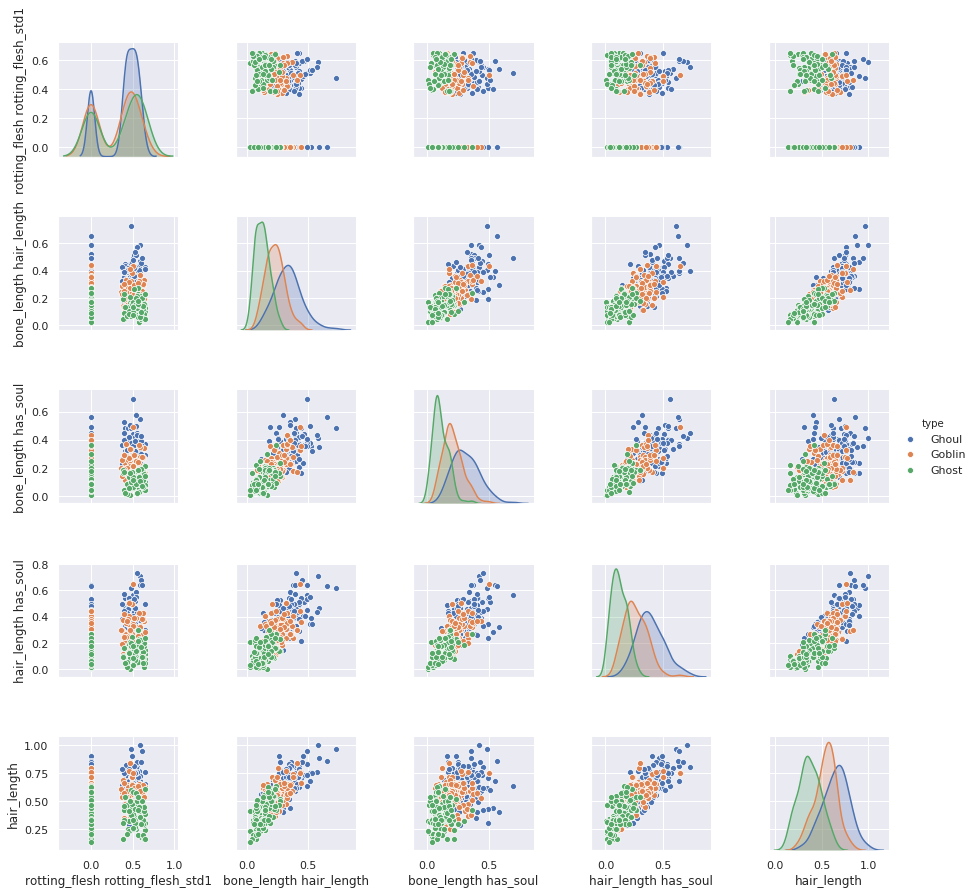

In [173]:
# top features per fi-algorithm
n = 4

sns.pairplot(
    data=X.join(y),
    hue='type',
    vars=list(set(fi.iloc[0].sort_values(ascending=False).head(n).index.tolist() +\
                  fi.iloc[1].sort_values(ascending=False).head(n).index.tolist() +\
                  fi.iloc[2].sort_values(ascending=False).head(n).index.tolist()))
);

The most important feature from all three ensemble algorithms is `hair_length`.

# EDA: `hair_length`

In [15]:
train.type.value_counts()

Ghoul     129
Goblin    125
Ghost     117
Name: type, dtype: int64

In [16]:
train_ = pd.DataFrame(X_, columns=X.columns).join(y)
train_r = pd.DataFrame(X_r, columns=X.columns).join(y)

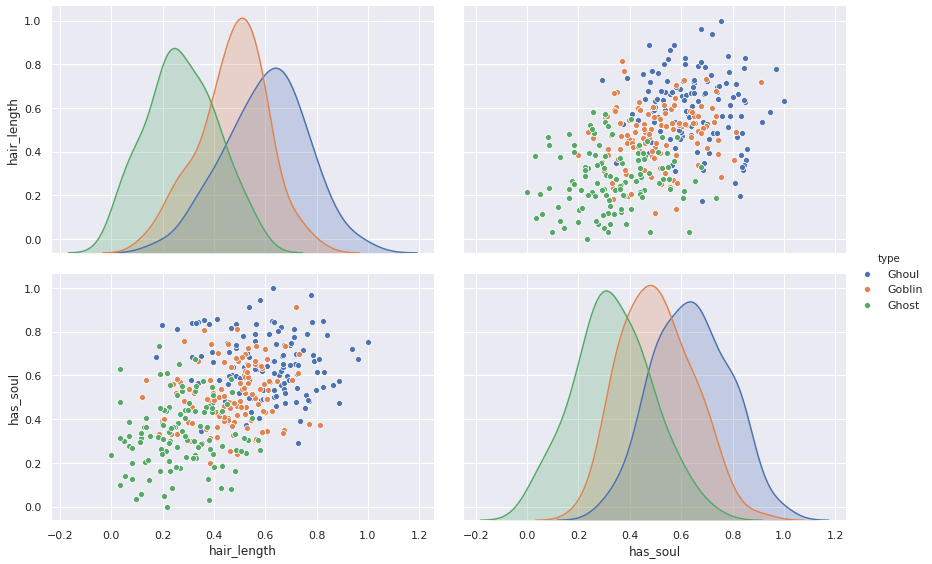

In [17]:
sns.pairplot(train_, hue='type', x_vars=[
    'hair_length',
    'has_soul',
], y_vars=[
    'hair_length',
    'has_soul',
], height=4, aspect=1.5);

# Feature Interactions

In [18]:
# define poly function for interactions
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)

# create interaction and cubic terms, including bias
poly_X = poly.fit_transform(X_)

# get column names from poly
poly_columns = poly.get_feature_names(X.columns)

fi = {}

for k,v in ensembles.items():
    fi[k] = v.fit(poly_X, y).feature_importances_

fi = pd.DataFrame.from_dict(fi, orient='index', columns=poly_columns)

fi.sort_values(fi.columns.tolist(), ascending=False, inplace=True)
fi.sort_values(fi.index.tolist(), axis=1, ascending=False, inplace=True)

fi.style.highlight_max(axis=1)

,bone_length hair_length has_soul,hair_length has_soul color_white,hair_length^2 has_soul,bone_length has_soul,has_soul^3,rotting_flesh^2 has_soul,bone_length rotting_flesh,hair_length has_soul,bone_length^2 has_soul,rotting_flesh hair_length,hair_length has_soul^2,bone_length hair_length^2,bone_length has_soul^2,bone_length^2 hair_length,rotting_flesh,rotting_flesh^3,rotting_flesh hair_length^2,bone_length,bone_length^2,bone_length rotting_flesh^2,rotting_flesh^2 hair_length,bone_length has_soul color_clear,bone_length hair_length color_white,bone_length rotting_flesh color_white,rotting_flesh hair_length color_white,rotting_flesh hair_length color_clear,bone_length hair_length color_green,bone_length hair_length color_black,bone_length hair_length,hair_length^2,hair_length,hair_length^3,has_soul^2,has_soul,bone_length rotting_flesh hair_length,rotting_flesh^2,rotting_flesh hair_length has_soul,bone_length^3,bone_length rotting_flesh has_soul,rotting_flesh has_soul^2,bone_length^2 rotting_flesh,rotting_flesh has_soul,hair_length color_white,has_soul^2 color_white,has_soul color_white,bone_length has_soul color_white,rotting_flesh color_white^2,hair_length has_soul color_clear,has_soul^2 color_clear,hair_length^2 color_white,hair_length^2 color_clear,hair_length color_white^2,bone_length^2 color_clear,hair_length color_clear^2,rotting_flesh color_white,rotting_flesh^2 color_white,has_soul color_white^2,bone_length color_white,rotting_flesh has_soul color_clear,has_soul color_clear^2,has_soul color_clear,bone_length hair_length color_clear,bone_length color_clear,rotting_flesh color_clear^2,bone_length color_white^2,hair_length color_clear,rotting_flesh^2 color_clear,bone_length color_clear^2,bone_length^2 color_white,rotting_flesh has_soul color_white,bone_length rotting_flesh color_clear,rotting_flesh color_clear,hair_length has_soul color_black,has_soul color_black^2,hair_length^2 color_green,has_soul^2 color_green,rotting_flesh color_green,hair_length has_soul color_green,has_soul^2 color_black,has_soul color_green^2,bone_length^2 color_black,hair_length color_green,rotting_flesh color_green^2,rotting_flesh color_black,hair_length color_black^2,has_soul color_black,hair_length^2 color_black,bone_length has_soul color_green,has_soul color_green,hair_length color_black,rotting_flesh^2 color_black,has_soul color_blue^2,rotting_flesh^2 color_green,hair_length color_green^2,color_white,rotting_flesh hair_length color_green,bone_length has_soul color_black,has_soul^2 color_blue,bone_length^2 color_green,bone_length color_green,rotting_flesh color_black^2,rotting_flesh has_soul color_green,bone_length has_soul color_blue,color_clear^3,bone_length rotting_flesh color_black,rotting_flesh color_blue^2,rotting_flesh hair_length color_black,color_black^3,rotting_flesh color_blue,hair_length has_soul color_blue,bone_length rotting_flesh color_green,rotting_flesh^2 color_blue,bone_length color_green^2,rotting_flesh has_soul color_blue,hair_length color_blue^2,rotting_flesh has_soul color_black,color_black,bone_length color_black,hair_length^2 color_blue,has_soul color_blue,color_clear,color_white^2,color_white^3,hair_length color_blue,color_green^2,bone_length rotting_flesh color_blue,bone_length color_black^2,color_clear^2,bone_length color_blue^2,bone_length^2 color_blue,color_blue^2,color_green,color_black^2,bone_length color_blue,bone_length hair_length color_blue,color_green^3,rotting_flesh hair_length color_blue,color_blue,hair_length color_blood^2,color_blue^3,rotting_flesh color_blood,bone_length^2 color_blood,hair_length^2 color_blood,rotting_flesh has_soul color_blood,bone_length hair_length color_blood,bone_length rotting_flesh color_blood,hair_length has_soul color_blood,hair_length color_blood,color_blood^2,has_soul^2 color_blood,has_soul color_blood,rotting_flesh color_blood^2,rotting_flesh^2 color_blood,bone_length color_blood,bone_length has_soul color_blood,rotting_flesh hair_length color_blood,has_soul color_blood^2,bon

In [19]:
# define poly function for interactions
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)

# create interaction and cubic terms, including bias
poly_X = poly.fit_transform(X_r)

# get column names from poly
poly_columns = poly.get_feature_names(X.columns)

fi = {}

for k,v in ensembles.items():
    fi[k] = v.fit(poly_X, y).feature_importances_

fi = pd.DataFrame.from_dict(fi, orient='index', columns=poly_columns)

fi.sort_values(fi.columns.tolist(), ascending=False, inplace=True)
fi.sort_values(fi.index.tolist(), axis=1, ascending=False, inplace=True)

fi.style.highlight_max(axis=1)

,hair_length^3,has_soul^3,rotting_flesh,bone_length^2 hair_length,bone_length hair_length has_soul,rotting_flesh has_soul color_white,hair_length,has_soul,bone_length,hair_length has_soul,bone_length has_soul^2,bone_length has_soul,hair_length has_soul color_white,hair_length^2 has_soul,bone_length^2 has_soul,bone_length hair_length,has_soul^2,rotting_flesh^2 hair_length,rotting_flesh^3,bone_length^3,rotting_flesh hair_length^2,has_soul color_clear,rotting_flesh has_soul^2,bone_length has_soul color_white,bone_length^2 color_clear,bone_length^2 color_white,has_soul color_green^2,hair_length has_soul^2,hair_length color_white,hair_length^2,hair_length color_white^2,rotting_flesh hair_length,bone_length hair_length^2,rotting_flesh^2 has_soul,has_soul color_white,bone_length^2,rotting_flesh has_soul,bone_length^2 rotting_flesh,bone_length rotting_flesh^2,has_soul color_clear^2,bone_length color_clear,rotting_flesh hair_length has_soul,rotting_flesh^2,bone_length rotting_flesh has_soul,bone_length rotting_flesh,bone_length color_clear^2,has_soul color_white^2,rotting_flesh color_white,hair_length color_clear^2,rotting_flesh color_white^2,bone_length rotting_flesh hair_length,bone_length color_white^2,hair_length color_clear,bone_length color_white,bone_length hair_length color_clear,has_soul^2 color_white,rotting_flesh hair_length color_white,bone_length hair_length color_white,has_soul^2 color_clear,rotting_flesh color_clear,rotting_flesh color_clear^2,rotting_flesh^2 color_white,hair_length^2 color_white,bone_length has_soul color_clear,hair_length has_soul color_clear,rotting_flesh^2 color_clear,bone_length rotting_flesh color_clear,rotting_flesh has_soul color_clear,bone_length rotting_flesh color_white,hair_length^2 color_clear,rotting_flesh hair_length color_clear,hair_length color_black^2,has_soul color_black,has_soul color_green,hair_length color_black,rotting_flesh hair_length color_black,bone_length color_black,has_soul color_black^2,color_white^3,hair_length color_green^2,bone_length color_black^2,bone_length^2 color_black,has_soul^2 color_green,bone_length color_green^2,rotting_flesh color_black,color_clear^2,hair_length color_green,bone_length rotting_flesh color_black,rotting_flesh hair_length color_green,bone_length has_soul color_green,rotting_flesh^2 color_black,rotting_flesh color_green^2,hair_length has_soul color_green,hair_length^2 color_green,color_clear,bone_length hair_length color_green,rotting_flesh color_green,rotting_flesh^2 color_green,bone_length color_green,bone_length rotting_flesh color_green,bone_length hair_length color_black,color_white,color_white^2,hair_length^2 color_black,rotting_flesh has_soul color_green,bone_length has_soul color_black,rotting_flesh color_black^2,color_clear^3,rotting_flesh has_soul color_black,bone_length^2 color_green,has_soul^2 color_black,rotting_flesh color_blue,rotting_flesh has_soul color_blue,rotting_flesh^2 color_blue,color_green,has_soul color_blue,color_black^2,color_green^3,has_soul^2 color_blue,bone_length color_blue,hair_length color_blood,color_black^3,hair_length has_soul color_black,rotting_flesh color_blue^2,rotting_flesh hair_length color_blue,hair_length color_blood^2,color_black,hair_length color_blue^2,hair_length has_soul color_blue,color_green^2,hair_length color_blue,bone_length hair_length color_blue,bone_length color_blue^2,has_soul color_blue^2,color_blood,hair_length^2 color_blue,bone_length rotting_flesh color_blue,bone_length^2 color_blue,hair_length has_soul color_blood,color_blue^2,rotting_flesh color_blood,hair_length^2 color_blood,color_blood^2,color_blue,rotting_flesh color_blood^2,rotting_flesh^2 color_blood,bone_length^2 color_blood,bone_length has_soul color_blue,rotting_flesh hair_length color_blood,bone_length color_blood^2,color_blue^3,bone_length hair_length color_blood,has_soul color_blood,has_soul color_blood^2,bone_length color_blood,bone_length has_soul color_blood,rotting_flesh has_soul color_blood,color_blood^3,bone_length 

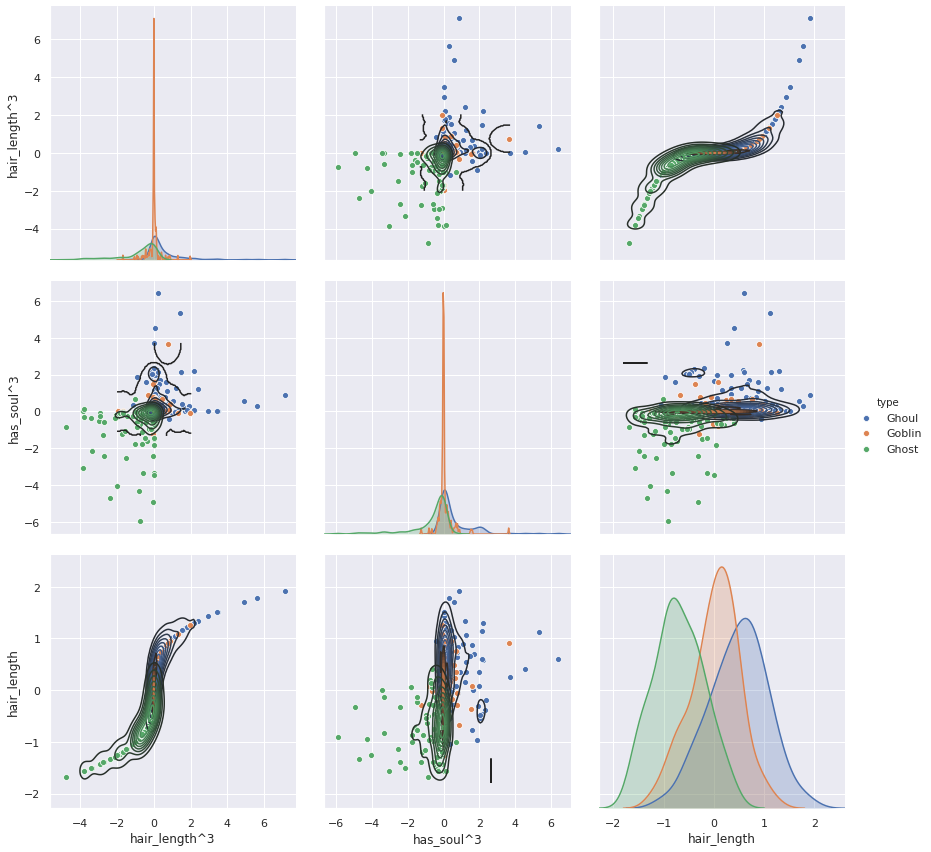

In [20]:
poly_train = pd.DataFrame(poly_X, columns=poly_columns).join(y)

g = sns.pairplot(poly_train, hue='type', x_vars=[
    'hair_length^3',
    'has_soul^3',
    'hair_length',
], y_vars=[
    'hair_length^3',
    'has_soul^3',
    'hair_length',
], height=4, aspect=1)

g.map_offdiag(sns.kdeplot);

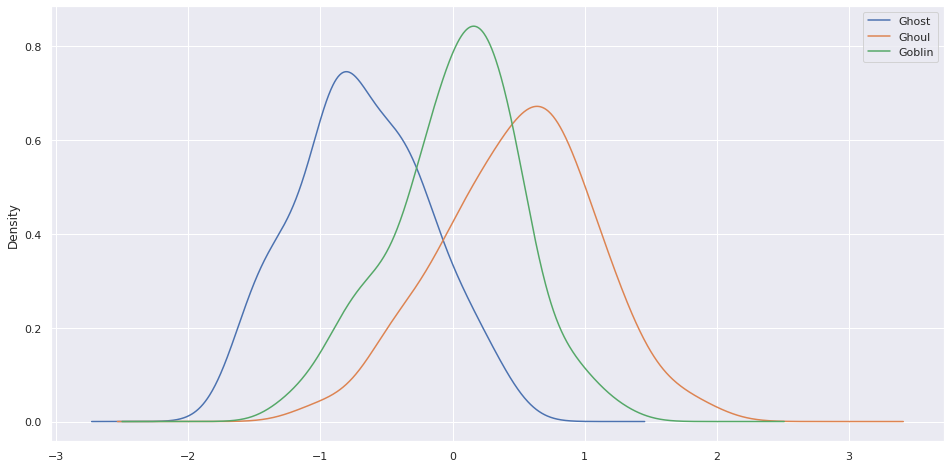

In [21]:
fig, ax = plt.subplots(figsize=(16,8))

poly_train.loc[
    poly_train.type == 'Ghost',
    'hair_length',
].plot.kde(ax=ax, label='Ghost')

poly_train.loc[
    poly_train.type == 'Ghoul',
    'hair_length',
].plot.kde(ax=ax, label='Ghoul')

poly_train.loc[
    poly_train.type == 'Goblin',
    'hair_length',
].plot.kde(ax=ax, label='Goblin')

ax.legend();

After using the `RobustScaler` and adding adding cubic interactions it can be seen that **Ghost**s' tend to have `hair_length` $\le 0$ and **Ghoul**s' have `hair_length` $\ge 0$.

**Goblin**s appear split $50$-$50$.

In [ ]:
# flag if hair length < 0 (aka < median)
train['hair_length_lt0'] = (train.hair_length < train.hair_length.median()).astype(int)

# Feature Importance Part II

In [ ]:
# select X features
X = train.drop(columns=[
    'id',
    'color',
    'type',
])

# select y for training
y = train.type

# define scaler
scaler = MinMaxScaler()
rscaler = RobustScaler()

# scale X
X_ = scaler.fit_transform(X)
X_r = rscaler.fit_transform(X)

# define poly function for interactions
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)

# create interaction and cubic terms, including bias
poly_X = poly.fit_transform(X_r)

# get column names from poly
poly_columns = poly.get_feature_names(X.columns)

fi = {}

for k,v in ensembles.items():
    fi[k] = v.fit(poly_X, y).feature_importances_

fi = pd.DataFrame.from_dict(fi, orient='index', columns=poly_columns)

fi.sort_values(fi.columns.tolist(), ascending=False, inplace=True)
fi.sort_values(fi.index.tolist(), axis=1, ascending=False, inplace=True)

fi.style.highlight_max(axis=1)

`has_soul` still appears important by itself even after cubic interactions.

# EDA: `has_soul`

In [ ]:
poly_train = pd.DataFrame(poly_X, columns=poly_columns).join(y)

g = sns.pairplot(poly_train, hue='type', x_vars=[
    'has_soul',
    'bone_length hair_length has_soul',
], y_vars=[
    'has_soul',
    'bone_length hair_length has_soul',
], height=4, aspect=1)

g.map_offdiag(sns.kdeplot);

Seems to be a similar situation for `has_soul`:
- **Ghost**s are $\le 0$
- **Ghoul**s are $\ge 0$
- **Goblin**s are split $50$-$50$

In [ ]:
# flag if has soul < 0 (aka < median)
train['has_soul_lt0'] = (train.has_soul < train.has_soul.median()).astype(int)

In [ ]:
# counts by combination of hair_length_lt0 and has_soul_lt0
train.groupby([
    'hair_length_lt0',
    'has_soul_lt0',
    'type',
]).id.count().unstack()

# Feature Importance: Part III

In [ ]:
# select X features
X = train.drop(columns=[
    'id',
    'color',
    'type',
])

# select y for training
y = train.type

# define scaler
scaler = MinMaxScaler()
rscaler = RobustScaler()

# scale X
X_ = scaler.fit_transform(X)
X_r = rscaler.fit_transform(X)

# define poly function for interactions
poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)

# create interaction and cubic terms, including bias
poly_X = poly.fit_transform(X_r)

# get column names from poly
poly_columns = poly.get_feature_names(X.columns)

fi = {}

for k,v in ensembles.items():
    fi[k] = v.fit(poly_X, y).feature_importances_

fi = pd.DataFrame.from_dict(fi, orient='index', columns=poly_columns)

fi.sort_values(fi.columns.tolist(), ascending=False, inplace=True)
fi.sort_values(fi.index.tolist(), axis=1, ascending=False, inplace=True)

fi.style.highlight_max(axis=1)

After adding the two flags, `bone_length` has shown some promise with quadratic and cubic interactions (when limiting to interaction only).

# EDA: `bone_length`

In [ ]:
poly_train = pd.DataFrame(poly_X, columns=poly_columns).join(y)

g = sns.pairplot(poly_train, hue='type', x_vars=[
    'bone_length',
    'hair_length',
], y_vars=[
    'bone_length',
    'hair_length',
], height=4, aspect=1)

g.map_offdiag(sns.kdeplot);

Similar situation:
- **Ghost**s `bone_length` $\le 0$
- **Ghoul**s `bone_length` $\ge 0$
- **Goblin**s split $50$-$50$

In [ ]:
# flag if bone length < 0 (aka < median)
train['bone_length_lt0'] = (train.bone_length < train.bone_length.median()).astype(int)

In [ ]:
# counts by combination of hair_length_lt0, has_soul_lt0, and bone_length_lt0
train.groupby([
    'hair_length_lt0',
    'has_soul_lt0',
    'bone_length_lt0',
    'type',
]).id.count().unstack()

- **Ghoul**s tend to be above the median on `hair_length`, `has_soul`, and `bone_length`.
- **Ghost**s tend to be below the median on `hair_length`, `has_soul`, and `bone_length`.
- **Goblin**s tend to be at the extremes (all above or all below).

In [ ]:
# shouldn't sum features like this as the model accounts for them better at an individual level

# # sum hair_length_lt0, has_soul_lt0, bone_length_lt0 flags
# train['lt0_sum_hair_soul_bone'] = train.hair_length_lt0 + train.has_soul_lt0 + train.bone_length_lt0

In [ ]:
# # counts by lt0_sum_hair_soul_bone
# train.groupby([
#     'lt0_sum_hair_soul_bone',
#     'type',
# ]).id.count().unstack()

# Feature Importance Part IV

In [ ]:
# select X features
X = train.drop(columns=[
    'id',
    'color',
    'type',
])

# select y for training
y = train.type

# define scaler
scaler = MinMaxScaler()
rscaler = RobustScaler()

# scale X
X_ = scaler.fit_transform(X)
X_r = rscaler.fit_transform(X)

# define poly function for interactions
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# create interaction and cubic terms, including bias
poly_X = poly.fit_transform(X_r)

# get column names from poly
poly_columns = poly.get_feature_names(X.columns)

fi = {}

for k,v in ensembles.items():
    fi[k] = v.fit(poly_X, y).feature_importances_

fi = pd.DataFrame.from_dict(fi, orient='index', columns=poly_columns)

fi.sort_values(fi.columns.tolist(), ascending=False, inplace=True)
fi.sort_values(fi.index.tolist(), axis=1, ascending=False, inplace=True)

fi.style.highlight_max(axis=1)

`rotting_flesh` has popped up in a few places:

- ~~`rotting_flesh^2 lt0_sum_hair_soul_bone` with cubic interaction~~
- `rotting_flesh` with quadratic interaction
- `rotting_flesh` with no interaction

# EDA: `rotting_flesh`

In [ ]:
poly_train = pd.DataFrame(poly_X, columns=poly_columns).join(y)

g = sns.pairplot(poly_train, hue='type', vars=[
    'rotting_flesh',
    'hair_length',
], height=4, aspect=1)

g.map_offdiag(sns.kdeplot);

In [ ]:
# flag if rotting flesh < 0 (aka < median)
train['rotting_flesh_lt0'] = (train.rotting_flesh < train.rotting_flesh.median()).astype(int)

In [ ]:
# counts by combination of hair_length_lt0, has_soul_lt0, bone_length_lt0, rotting_flesh_lt0
train.groupby([
    'hair_length_lt0',
    'has_soul_lt0',
    'bone_length_lt0',
    'rotting_flesh_lt0',
    'type',
]).id.count().unstack()

At this rate, there could be some kind of interaction effect between all of my `lt0` features.

I have $4$ of them, so let's use 4-way interaction terms.

In [ ]:
# select X features
X = train.drop(columns=[
    'id',
    'color',
    'type',
])

# select y for training
y = train.type

# define scaler
scaler = MinMaxScaler()
rscaler = RobustScaler()

# define vt
vt = VarianceThreshold()

# define selector
selector = SelectPercentile()

# scale X
X_ = scaler.fit_transform(X)
X_r = rscaler.fit_transform(X)

# define poly function for interactions
# include interaction only
poly = PolynomialFeatures(degree=4, interaction_only=True, include_bias=False)

# create interaction and cubic terms, including bias
poly_X = poly.fit_transform(X_r)

# remove fields with no variance
poly_X = vt.fit_transform(poly_X)

# keep top 10% of best fields
poly_X = selector.fit_transform(poly_X, y)

# get boolean support on vt fields
vt_columns = vt.get_support()

# get boolean support on selector fields
selector_columns = selector.get_support()

# get column names from poly
poly_columns = np.array(poly.get_feature_names(X.columns))[vt_columns][selector_columns]

fi = {}

for k,v in ensembles.items():
    fi[k] = v.fit(poly_X, y).feature_importances_

fi = pd.DataFrame.from_dict(fi, orient='index', columns=poly_columns)

fi.sort_values(fi.columns.tolist(), ascending=False, inplace=True)
fi.sort_values(fi.index.tolist(), axis=1, ascending=False, inplace=True)

fi.style.highlight_max(axis=1)

# Correlation

In [ ]:
# put the poly data into a dataframe
poly_df = pd.DataFrame(
    data=poly_X,
    index=X.index,
    columns=poly_columns
)

In [ ]:
# heatmap of correlation
fig, ax = plt.subplots(figsize=(16,8))

sns.heatmap(poly_df.corr(), ax=ax);

In [ ]:
# store fields with "high" correlation (> 0.6)
corr = {}

for c in poly_df.columns:
    corr[c] = poly_df.corr()[c].where(lambda x : x.abs() > 0.6).dropna()

# Principal Component Analysis

In [ ]:
# define pca (retain 99% of explainable variance)
pca = PCA(n_components=0.99)

In [ ]:
corr_pca = {}

for k,v in corr.items():
    corr_pca[k] = pca.fit_transform(poly_df.loc[:, v.index])

In [ ]:
corr_v = set()

for k,v in corr.items():
    corr_v = corr_v.union(set([k]))
    corr_v = corr_v.union(set(v.index))

In [ ]:
train_pca = pd.DataFrame()

In [ ]:
for k,v in corr_pca.items():
    train_pca = pd.concat([
        train_pca,
        pd.DataFrame(v).add_prefix(f"{k}_")
    ], axis=1)

In [ ]:
tpc = train_pca.corr()

tpc.sort_values(tpc.columns.tolist(), inplace=True)

tpc.sort_values(tpc.index.tolist(), axis=1, inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))

sns.heatmap(tpc, ax=ax)

In [ ]:
train_pca = train_pca.join(y)

In [ ]:
# select X features
X = train_pca.drop(columns=[
#     'id',
#     'color',
    'type',
])

# select y for training
y = train_pca.type

# define scaler
scaler = MinMaxScaler()
rscaler = RobustScaler()

# define vt
vt = VarianceThreshold()

# define selector
selector = SelectPercentile()

# scale X
X_ = scaler.fit_transform(X)
X_r = rscaler.fit_transform(X)

# define poly function for interactions
# include interaction only
poly = PolynomialFeatures(degree=4, interaction_only=True, include_bias=False)

# create interaction and cubic terms, including bias
# poly_X = poly.fit_transform(X_r)
poly_X = X_r

# remove fields with no variance
poly_X = vt.fit_transform(poly_X)

# keep top 10% of best fields
poly_X = selector.fit_transform(poly_X, y)

# get boolean support on vt fields
vt_columns = vt.get_support()

# get boolean support on selector fields
selector_columns = selector.get_support()

# get column names from poly
# poly_columns = np.array(poly.get_feature_names(X.columns))[vt_columns][selector_columns]
poly_columns = np.array(X.columns)[vt_columns][selector_columns]

fi = {}

for k,v in ensembles.items():
    fi[k] = v.fit(poly_X, y).feature_importances_

fi = pd.DataFrame.from_dict(fi, orient='index', columns=poly_columns)

fi.sort_values(fi.columns.tolist(), ascending=False, inplace=True)
fi.sort_values(fi.index.tolist(), axis=1, ascending=False, inplace=True)

fi.style.highlight_max(axis=1)

In [ ]:
g = sns.pairplot(train_pca, hue='type', vars=[
    'hair_length_lt0 has_soul_lt0_0',
    'hair_length has_soul hair_length_lt0 has_soul_lt0_0',
    'bone_length bone_length_lt0_0'
], height=4, aspect=1.5)

g.map_offdiag(sns.kdeplot);

# Model

In [242]:
train_x, test_x, train_y, test_y = train_test_split(X_r, y, test_size=0.1, random_state=0)

In [243]:
results = {}

for k,v in classifiers.items():
    
    print(k)
    
    cv = cross_validate(
        estimator=v,
        X=train_x,
        y=train_y,
        cv=10
    )
    
    cv = cv['test_score']
    
    results[k] = cv

AdaBoostClassifier
ExtraTreesClassifier
RandomForestClassifier
LogisticRegression
GaussianNB
GaussianProcessClassifier
KNeighborsClassifier
MLPClassifier


/home/ian/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ian/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ian/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ian/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  %

LinearSVC


/home/ian/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ian/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ian/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ian/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/ian/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the

SVC


In [260]:
classifiers['LogisticRegression']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [244]:
# selector 10
pd.DataFrame.from_dict(results, orient='columns').describe()

,AdaBoostClassifier,ExtraTreesClassifier,RandomForestClassifier,LogisticRegression,GaussianNB,GaussianProcessClassifier,KNeighborsClassifier,MLPClassifier,LinearSVC,SVC
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.531457,0.692332,0.719331,0.743312,0.601062,0.700246,0.715828,0.677573,0.740192,0.719127
std,0.131485,0.064851,0.073496,0.082689,0.039683,0.087880,0.098783,0.065602,0.088774,0.087267
min,0.281250,0.575758,0.562500,0.593750,0.542857,0.531250,0.562500,0.562500,0.625000,0.531250
25%,0.462121,0.666430,0.709099,0.699449,0.577009,0.666430,0.666430,0.656473,0.661305,0.694196
50%,0.550840,0.707860,0.739076,0.750216,0.599905,0.712121,0.750216,0.666667,0.764502,0.735065
75%,0.617898,0.735294,0.757576,0.789394,0.631684,0.757353,0.764706,0.694156,0.796970,0.780303
max,0.705882,0.771429,0.800000,0.878788,0.656250,0.828571,0.878788,0.794118,0.878788,0.823529


In [283]:
g = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'random_state' : [0],
        'penalty' : ['l1', 'l2'],
        'C' : np.arange(1e-2, 1e1, 1e-1),
        'fit_intercept' : [True],
        'max_iter' : [200],
        'solver' : ['liblinear'],
        'multi_class' : ['auto'],
    },
    cv=10,
)

g.fit(train_x, train_y)

print(g.best_score_)

In [304]:
scores = cross_val_score(
    estimator=g.best_estimator_,
    X=train_x,
    y=train_y,
    cv=10
)

count    10.000000
mean      0.755460
std       0.078178
min       0.625000
25%       0.711230
50%       0.768939
75%       0.800000
max       0.878788
dtype: float64


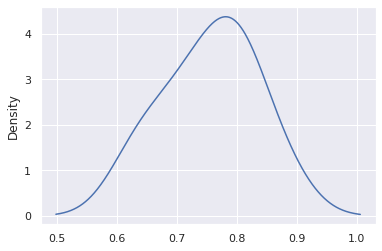

In [312]:
print(pd.Series(scores).describe())

pd.Series(scores).plot.kde();

In [335]:
pd.DataFrame(classification_report(
    y_true=test_y,
    y_pred=g.best_estimator_.predict(test_x),
    output_dict=True
))

,Ghost,Ghoul,Goblin,accuracy,macro avg,weighted avg
precision,0.875000,0.75,0.600000,0.763158,0.741667,0.755921
recall,0.933333,0.75,0.545455,0.763158,0.742929,0.763158
f1-score,0.903226,0.75,0.571429,0.763158,0.741551,0.758792
support,15.000000,12.00,11.000000,0.763158,38.000000,38.000000
